In [1]:
%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
#optional for nicer plots
import seaborn
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [2]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

# Load stuff

In [3]:
os.listdir

<function posix.listdir(path=None)>

In [4]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 0

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [5]:
all_data_folders

['2021-07-26_39955_ks25',
 '2021-07-27_39955_ks25',
 '2021-07-27_39965_ks25',
 '2021-07-28_39965_ks25',
 '2021-07-31_39951_ks25',
 '2021-08-04_39951_ks25',
 '2021-08-06_39964_ks25',
 '2021-08-12_39964_ks25']

In [6]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)       #the port poked was port
                                            #add your filter of interest here...
                                           ].index           

            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [7]:
firing_rate_maps = get_task_responses(task_event_df,response_table)

In [8]:
#
ccs_across = []
for r1,r2 in zip(firing_rate_maps[:,:,0],firing_rate_maps[:,:,1]):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.5041139757310369


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [9]:
task_event_df['target'].unique()

array([1, 5, 7, 4, 8, 2, 0, 3, 6])

In [10]:
eval(task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['current_sequence'])

[8, 4, 2, 5, 7, 0, 6, 1, 3]

In [11]:
#this is the map from the 
task_sequence_0 = eval(task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['current_sequence'])
task_sequence_1 = eval(task_event_df.loc[task_event_df['task_nr']==1].iloc[0]['current_sequence'])

graph_type_0 = task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['graph_type']
graph_type_1 = task_event_df.loc[task_event_df['task_nr']==1].iloc[0]['graph_type']

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


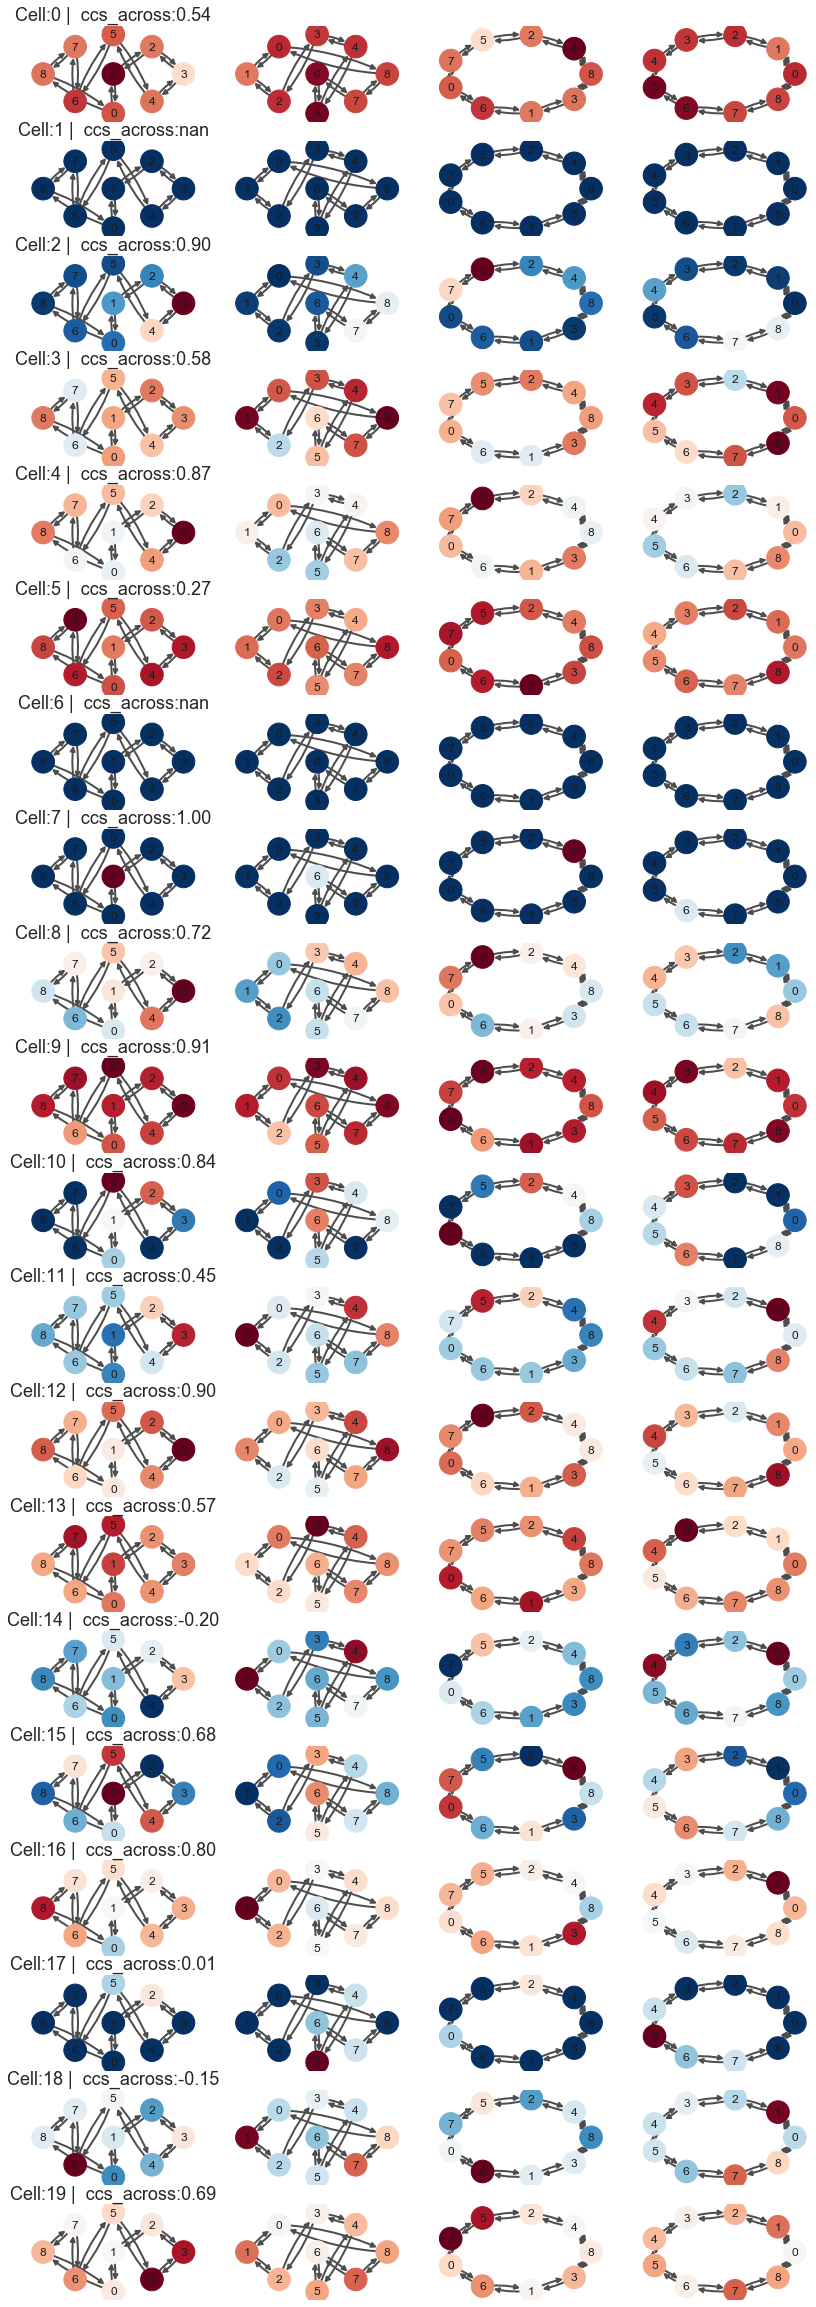

In [12]:
resps_state_g1 = firing_rate_maps[:,:,0][:,task_sequence_0]
resps_state_g2 = firing_rate_maps[:,:,1][:,task_sequence_1]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
n_units = firing_rate_maps.shape[0]
for i in range(20):

    spks1 = firing_rate_maps[:,:,0][i]
    spks2 = firing_rate_maps[:,:,1][i]
    mx = np.nanmax(np.concatenate([spks1,spks2]))
    mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
    plt.subplot(n_plot,4,4*ctr+1)
    plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

    spks = spks1
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='poke',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+2)
    spks = spks2
    plot_activity_on_graph(task_sequence_1,graph_type_1,
                           spks=spks,order='poke',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[i]
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='state',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[i]
    plot_activity_on_graph(np.arange(9).tolist(),graph_type_1,
                           spks=spks,order='state',mx=mx,mn=mn)

    ctr +=1